In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.rcParams["figure.figsize"] = (10,6)


In [14]:
def toy_data(n, seed=0):
    np.random.seed(seed)
    x = np.random.normal(0, 1, (n, 8))
    z_xf = 0.4 * x[:, 0] - 0.5 * x[:, 1] + 1.75 * x[:, 2] - 0.2 * x[:,
                                                                    3] + x[:,
                                                                           4]
    z = np.reshape(z_xf, (n, 1))
    y = np.random.random((n, 1)) > 1 / (1 + np.exp(-z))
    return np.hstack((x, y))


In [15]:
def log_loss(y, p):
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

In [16]:
def first_task(dgp):
    train_small = toy_data(50)
    x, y = train_small[:, :-1], train_small[:, -1]
    h = LogisticRegression(max_iter=1000).fit(x, y)
    p = h.predict_proba(dgp[:, :-1])
    true_risk = np.mean(log_loss(dgp[:, -1], p[:, 1]))
    estimated_risk = []
    std_err = []
    is_CI = []
    for i in range(1000):
        new_test_small = toy_data(50, i + 10)  # (i+5)*2371)
        p = h.predict_proba(new_test_small[:, :-1])
        l = log_loss(new_test_small[:, -1], p[:, 1])
        estimated_risk.append(np.mean(l))
        std_err.append(np.std(l) / np.sqrt(50))
        left_CI = estimated_risk[-1] - 1.96 * std_err[-1]
        right_CI = estimated_risk[-1] + 1.96 * std_err[-1]
        is_CI.append(left_CI < true_risk < right_CI)

    print('---------------- [REPORT]:FIRST TASK ----------------')
    print('True risk:', true_risk)
    mean_diff = np.mean(estimated_risk - true_risk)
    print('Mean difference:', mean_diff)
    point_five_b_tr = np.mean(
        log_loss(dgp[:, -1], np.array([0.5] * dgp.shape[0])))
    print('0.5-0.5 baseline true risk: ', point_five_b_tr)
    print('Median standard error: ', np.median(std_err))
    print('Precentage of 95CI that contain the true risk proxy: ',
          np.sum(is_CI) / len(is_CI))
    plt_data = estimated_risk - np.array([true_risk] * 1000)
    sns.kdeplot(plt_data, fill=True)
    plt.xlabel('Estimated risk - True risk ')
    plt.title('Model loss estimator variability due to test data variability')

    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.savefig('1st_est-TrueRisk.png')
    plt.clf()

In [21]:
def second_task(dgp):
    diff = []
    for i in range(50):
        train_small1 = toy_data(50, i + 10)
        train_small2 = toy_data(50, i + 9)
        x, y = train_small1[:, :-1], train_small1[:, -1]
        h1 = LogisticRegression(max_iter=1000).fit(x, y)
        train_bulk = np.concatenate([train_small1, train_small2])
        x, y = train_bulk[:, :-1], train_bulk[:, -1]
        h2 = LogisticRegression(max_iter=1000).fit(x, y)
        p1 = h1.predict_proba(dgp[:, :-1])
        true_risk1 = np.mean(log_loss(dgp[:, -1], p1[:, 1]))
        p2 = h2.predict_proba(dgp[:, :-1])
        true_risk2 = np.mean(log_loss(dgp[:, -1], p2[:, 1]))
        diff.append(true_risk1 - true_risk2)
    print('---------------- [REPORT]:SECOND TASK ----------------')
    print(pd.DataFrame(diff).describe())

In [23]:
def third_task(dgp):
    train_small = toy_data(100)
    x, y = train_small[:, :-1], train_small[:, -1]
    h0 = LogisticRegression(max_iter=1000).fit(x, y)
    p = h0.predict_proba(dgp[:, :-1])
    true_risk = np.mean(log_loss(dgp[:, -1], p[:, 1]))

    estimated_risk = []
    std_err = []
    is_CI = []
    np.random.seed(19237)
    for i in range(1000):
        rnd_indices_train = np.random.choice(train_small.shape[0],
                                             size=50,
                                             replace=False)
        mask = np.ones(100, dtype=bool)
        mask[rnd_indices_train] = False
        rnd_indices_test = mask
        x, y = train_small[rnd_indices_train, :-1], train_small[
            rnd_indices_train, -1]
        h = LogisticRegression(max_iter=1000).fit(x, y)
        p = h.predict_proba(train_small[rnd_indices_test, :-1])
        l = log_loss(train_small[rnd_indices_test, -1], p[:, 1])
        estimated_risk.append(np.mean(l))
        std_err.append(np.std(l) / np.sqrt(50))
        left_CI = estimated_risk[-1] - 1.96 * std_err[-1]
        right_CI = estimated_risk[-1] + 1.96 * std_err[-1]
        is_CI.append(left_CI < true_risk < right_CI)
    print('---------------- [REPORT]:THIRD TASK ----------------')
    print('True risk:', true_risk)
    mean_diff = np.mean(estimated_risk - true_risk)
    print('Mean difference:', mean_diff)
    print('Median standard error: ', np.median(std_err))
    print('Precentage of 95CI that contain the true risk proxy: ',
          np.sum(is_CI) / len(is_CI))
    plt_data = estimated_risk - np.array([true_risk] * 1000)
    sns.kdeplot(plt_data, fill=True)
    plt.xlabel('Estimated risk - True risk ')
    plt.title('Loss estimator variability due to split variability')
    plt.grid()
    plt.tight_layout()
    plt.savefig('3rd_est-TrueRisk.png')
    plt.show()
    plt.clf()


In [25]:
def cv(data, model, k=5):
    subsets = np.array(np.squeeze(np.split(data, k)))
    _res = []
    for i, _set in enumerate(subsets):
        validate = subsets[i]
        _train = np.concatenate(np.delete(subsets, i, axis=0))
        _nx = _train[:, :-1]
        _y = _train[:, -1]
        model.fit(_nx, _y)
        _xx = validate[:, :-1]
        _yy = validate[:, -1]
        _yp = model.predict_proba(_xx)[:, 1]
        _res.append(log_loss(_yy, _yp))
    return np.ravel(_res)


In [26]:
def fourth_task(dgp):
    cv_2f, cv_4f, cv_10f = [], [], []

    def get_scores(cv, tr):

        std_err = np.std(cv) / np.sqrt(100)
        left_CI = np.mean(cv) - 1.96 * std_err
        right_CI = np.mean(cv) + 1.96 * std_err
        is_CI = left_CI < tr < right_CI
        return np.mean(cv), std_err, is_CI

    for i in range(500):

        train_small = toy_data(100, i + 5)
        x, y = train_small[:, :-1], train_small[:, -1]
        h0 = LogisticRegression(max_iter=1000).fit(x, y)
        p = h0.predict_proba(dgp[:, :-1])
        true_risk = np.mean(log_loss(dgp[:, -1], p[:, 1]))
        cv_2f.append(get_scores(cv(train_small, h0, 2), true_risk))
        cv_4f.append(get_scores(cv(train_small, h0, 4), true_risk))
        cv_10f.append(get_scores(cv(train_small, h0, 10), true_risk))
    labels = ['2-fold', '4-fold', '10-fold']

    print('---------------- [REPORT]:FOURTH TASK ----------------')
    print('True risk:', true_risk)

    for i, _cv in enumerate([cv_2f, cv_4f, cv_10f]):
        print(labels[i] + 'CV:')
        print("Estimated risk: ", np.mean([x[0] for x in _cv]))
        print("Mean difference: ", np.mean([x[0] - true_risk for x in _cv]))
        print("Median standard error: ", np.median([x[1] for x in _cv]))
        is_CI = [x[2] for x in _cv]
        print('Precentage of 95CI that contain the true risk proxy: ',
              np.sum(is_CI) / len(is_CI))
        data = [x[0] for x in _cv]
        sns.kdeplot(data, fill=True)
        plt.title(labels[i])
        plt.grid()
        plt.tight_layout()
        plt.savefig(labels[i] + '.png')
        plt.show()
        plt.clf()


In [17]:
dgp = toy_data(100000, 5678912)

### Setup

Toy dataset is generated with 100,000 examples. 

This is used to estimate true risk of the obeserved model and test its behavior in different setups of DGP. 

The model used is scikit-learn Logistic regression without default hyper-parameters values. 

Following the law of Large Numbers we can claim that the estimate will converge to the true risk and with Central Limit Theorem ( i.e. variance of the estimator will be n times smaller then variance of the loss function), we can say that with 100,000 examples we derive approx. 300 times smaller standard deviation, which is in the area of 3rd decimal difference. 

In [29]:
print('Setup')
print(
    'Toy dataset is generated with 100,000 examples. This is used to estimate true risk of the obeserved model and test its behavior in different setups of DGP. The model used is scikit-learn Logistic regression without default hyper-parameters values. Following the law of Large Numbers we can claim that the estimate will converge to the true risk and with Central Limit Theorem ( i.e. variance of the estimator will be n times smaller then variance of the loss function), we can say that with 100,000 examples we derive approx. 300 times smaller standard deviation, which is in the area of 3rd decimal difference. '
)

Setup
Toy dataset is generated with 100,000 examples. This is used to estimate true risk of the obeserved model and test its behavior in different setups of DGP. The model used is scikit-learn Logistic regression without default hyper-parameters values. Following the law of Large Numbers we can claim that the estimate will converge to the true risk and with Central Limit Theorem ( i.e. variance of the estimator will be n times smaller then variance of the loss function), we can say that with 100,000 examples we derive approx. 300 times smaller standard deviation, which is in the area of 3rd decimal difference. 


---------------- [REPORT]:FIRST TASK ----------------
True risk: 0.5568268088524259
Mean difference: 0.0038728213478375195
0.5-0.5 baseline true risk:  0.6931471805599453
Median standard error:  0.0772592230027738
Precentage of 95CI that contain the true risk proxy:  0.942


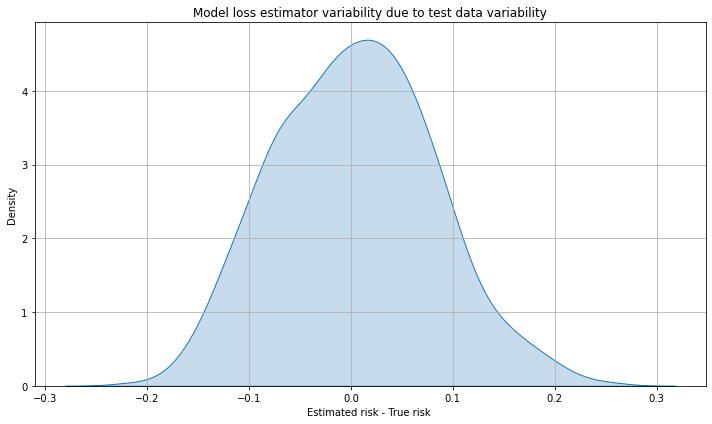

<Figure size 720x432 with 0 Axes>

In [20]:
# Model loss estimator variability due to test data variability
first_task(dgp)

' We can assume that increasing training set would lower the model true risk while leaving same variability on the test set if it is left unchanged. Increasing the test set would yield same true risk, but the variance of the estimated - true would be lower'
    

In [22]:
# Overestimation of the deployed model’s risk

second_task(dgp)

---------------- [REPORT]:SECOND TASK ----------------
               0
count  50.000000
mean    0.045163
std     0.047483
min    -0.065325
25%     0.015871
50%     0.043190
75%     0.072056
max     0.211791


'Increasing data set sizes should yield smaller variance of the mean difference and actual value lower. We can also conclude that the models true risk is lowered with more training data.'

---------------- [REPORT]:THIRD TASK ----------------
True risk: 0.48422101283512836
Mean difference: 0.10361405884999576
Median standard error:  0.08802617297854554
Precentage of 95CI that contain the true risk proxy:  0.926


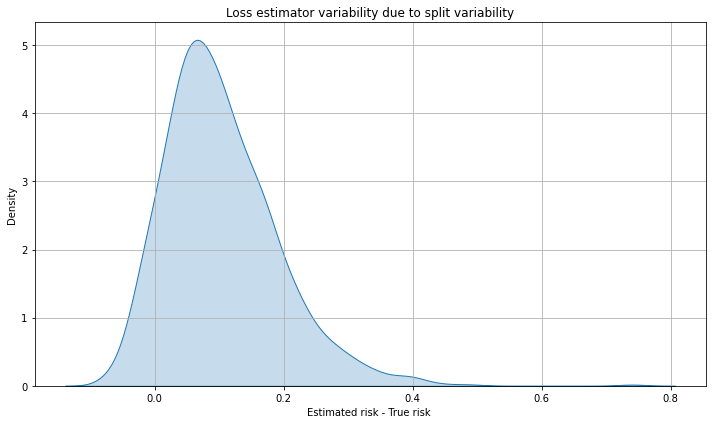

<Figure size 720x432 with 0 Axes>

In [24]:
# # Loss estimator variability due to split variability

third_task(dgp)

'As expected, model trained with less data on average has higher risk. Due to actual data variability we can see that model risk has true risk in wide range of values. With increased batch of data we can expect for true risk to lower in value and  to yield lower mean difference of two models. '

---------------- [REPORT]:FOURTH TASK ----------------
True risk: 0.48376424653801053
2-foldCV:
Estimated risk:  0.5337803509886773
Mean difference:  0.05001610445066667
Median standard error:  0.06113303761555557
Precentage of 95CI that contain the true risk proxy:  0.818


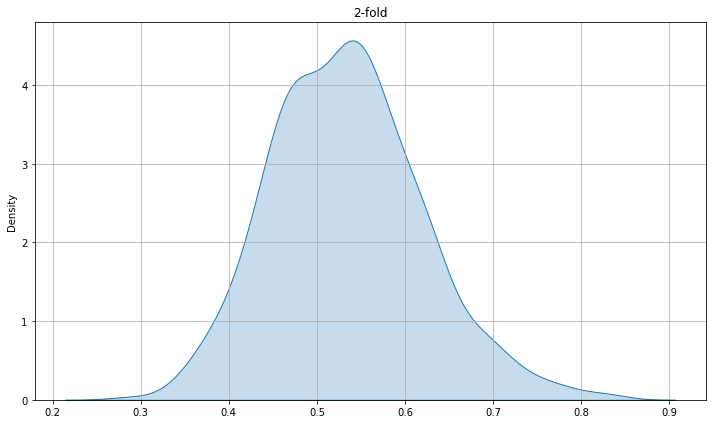

4-foldCV:
Estimated risk:  0.5059941943224376
Mean difference:  0.022229947784427124
Median standard error:  0.059681170785227985
Precentage of 95CI that contain the true risk proxy:  0.882


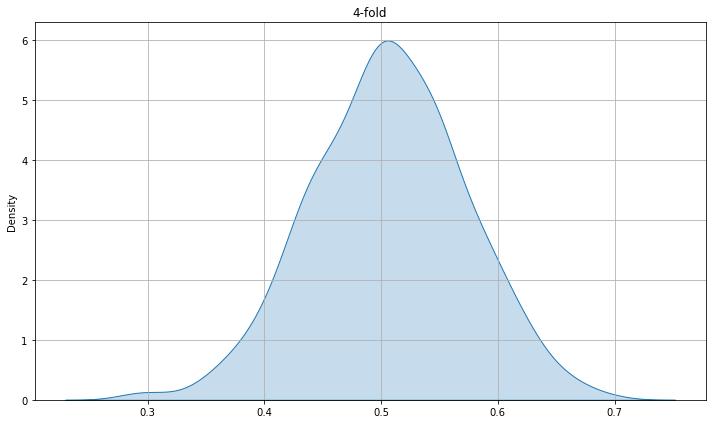

10-foldCV:
Estimated risk:  0.4965449485656503
Mean difference:  0.012780702027639743
Median standard error:  0.059222557511689894
Precentage of 95CI that contain the true risk proxy:  0.914


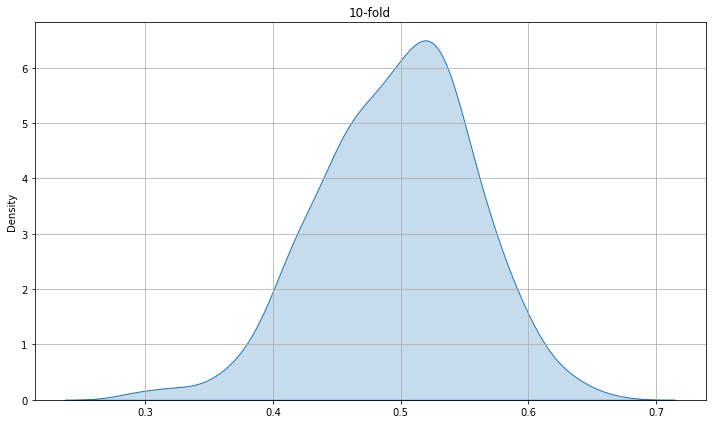

<Figure size 720x432 with 0 Axes>

In [27]:
# Cross-validation

fourth_task(dgp)

We can see that higher k in k-fold CV results in overestimation of the true risk. Standard errors are almost inert in different k-folds. Variability is present in all cases, which inherited from splits and losses.